In [11]:
#double tbSim(n, channel) ;
#double tbObs(n, channel) ;
#int64 pType(n) ;
#float sfcEmiss(n, channel) ;
#float skTemp(n) ;
#skTemp:_FillValue = NaNf ;
#double wvp(n) ;
#double iwp(n) ;
#double rwp(n) ;

import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt


with nc.Dataset("/Volumes/T7 Shield/SUBSETS/output/training_dataset_land_2d_0to120step2.nc") as f:
    tbSim = f.variables["tbConv"][:,4,3,:]
    tbObs = f.variables["tbObs"][:,4,3,:]
    pType = f.variables["pType"][:]
    sfcEmiss = f.variables["sfcEmiss"][:]
    skTemp = f.variables["skTemp"][:,4,3]
    wvp = f.variables["wvp"][:]
    iwp = f.variables["iwp"][:]
    rwp = f.variables["rwp"][:]
    sfcBin= f.variables["sfcBin"][:,4,3]
    stormTop= f.variables["stormTop"][:]
    zeroDeg= f.variables["zeroDeg"][:,4,3]
    sfcPrecip= f.variables["sfcPrecip"][:]
    
    

In [47]:
print(zeroDeg.shape)
print(stormTop.shape)
print(sfcPrecip.shape)
tbm=tbSim.mean(axis=0)
tbstd=tbSim.std(axis=0)
tb_scaled=(tbSim-tbm)/tbstd
a=np.nonzero(zeroDeg>0)
print(len(a[0]))
astorm=np.nonzero(stormTop.data!=stormTop.data)
stormTop[astorm]=0
x_input=np.concatenate((tb_scaled[a[0],:9],(skTemp[a[0]][:,None]-273.15)/10,(88-sfcBin[a[0]][:,None])/30.,stormTop[a[0]][:,None]/10e3,zeroDeg[a[0],None]/1e3,np.log10(1+iwp[a]/10)[:,None],np.log10(1+rwp[a]/10)[:,None]),axis=1)

(1874740,)
(1874740,)
(1874740,)
1867874


In [48]:
print(x_input.shape)

(1867874, 15)


In [41]:
print(x_input.mean(axis=0))
print(x_input.shape)

[-3.25244345e-02 -4.09387079e-03 -4.50486722e-02 -2.09538815e-02
 -4.39659030e-02 -5.67476722e-02 -2.77247242e-02 -5.26481518e-02
 -4.15734295e-02  2.01921152e+00  9.90383363e-02  4.29559078e-02
  3.68619287e+00  1.07195627e-03  3.02934519e-04]
(1867874, 15)


[-0.03252443 -0.00409387 -0.04504867 -0.02095388 -0.0439659  -0.05674767
 -0.02772472 -0.05264815 -0.04157343  2.01921152  0.09903834  0.04295591
  3.68619287]


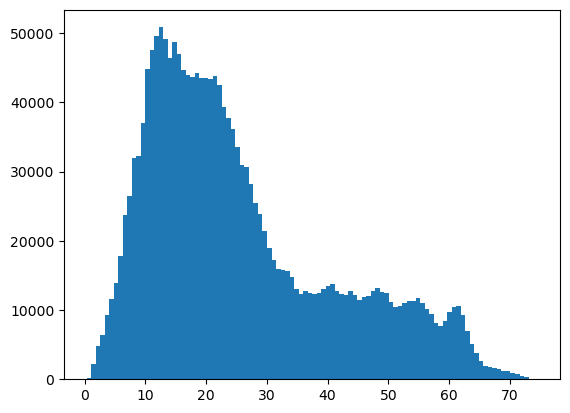

In [29]:
h1=plt.hist(wvp[a]*1000,bins=100)
print(x_input.mean(axis=0))
tb_scaling={'mean':tbm,'std':tbstd}
import pickle
pickle.dump(tb_scaling,open('tb_scaling.pklz','wb'))

In [30]:
y_out=np.concatenate((sfcEmiss[a[0],0:9],wvp[a[0]][:,None]*1e2,np.log10(1+sfcPrecip[a[0]]/10.)[:,None]),axis=1)
print(y_out.mean(axis=0))

[0.93160325 0.8636856  0.93693215 0.8758585  0.9358502  0.9389324
 0.8834868  0.903387   0.8965662  2.572739   0.00369234]


In [50]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_input, y_out, test_size=0.2, random_state=42)
print(y_test.shape)
print(x_test.shape)

(373575, 11)
(373575, 15)


In [51]:
# define convolutional neural network to predict gvars from x_forward

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def feed_forward_model(nout=13):
    model = keras.Sequential()
    model.add(layers.Dense(64, input_dim=15, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(nout, activation=None))

    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

all_sky = feed_forward_model(nout=11)

In [52]:
hist=all_sky.fit(x_train, y_train, epochs=5, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/5
46697/46697 [==============================] - 28s 591us/step - loss: 0.0209 - val_loss: 0.0137
Epoch 2/5
46697/46697 [==============================] - 28s 593us/step - loss: 0.0131 - val_loss: 0.0109
Epoch 3/5
46697/46697 [==============================] - 27s 585us/step - loss: 0.0115 - val_loss: 0.0116
Epoch 4/5
46697/46697 [==============================] - 27s 586us/step - loss: 0.0107 - val_loss: 0.0111
Epoch 5/5
46697/46697 [==============================] - 27s 585us/step - loss: 0.0103 - val_loss: 0.0096


In [53]:
all_sky.save('all_sky.h5')

/Users/mgrecu/miniconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
